# 関数のテスト

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import calc_variogram as variogram
import kriging_est as kriging

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')
data['price'] = np.log(data.price)

Step1: OLSから残差を算出

In [7]:
x = data[['station', 'tokyo']]
y = data['price']

In [10]:
step1 = sm.OLS(y, x)
step1_res = step1.fit()
resid = step1_res.resid

Step2: 残差からvariogramを推定

In [11]:
resid = pd.DataFrame(resid, columns=['residuals'])
resid = data[['px', 'py']].join(resid)
resid = resid.values

In [12]:
vario = variogram.get_diff(resid)

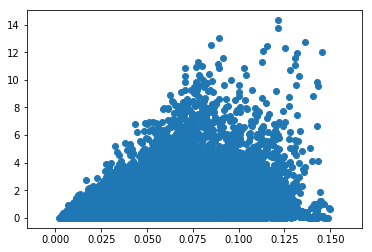

In [15]:
plt.scatter(vario[0], vario[1])

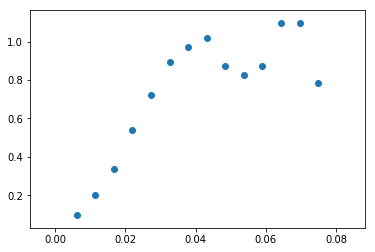

In [17]:
e_vario, lag = variogram.emp_variogram(vario, 14)
plt.scatter(e_vario[0], e_vario[1])

[  0.         100.           0.25772863  11.83045977]
[1.00000000e+00 1.00000000e+02 2.51870094e-19 9.55335130e-01
 2.28943081e-02]
[2.00000000e+00 1.00000000e+02 8.32742902e-17 1.10239909e+00
 2.89467942e-02]
[3.00000000e+00 1.00000000e+02 7.95844448e-22 9.46576789e-01
 4.96359269e-02]
[0.        0.0091617 0.0183234 0.0274851 0.0366468 0.0458085 0.0549702
 0.0641319 0.0732936 0.0824553]
[0.        0.0091617 0.0183234 0.0274851 0.0366468 0.0458085 0.0549702
 0.0641319 0.0732936 0.0824553] 0.9553351302689328 0.02289430808576946
[1.00000000e+00 1.00000000e+02 2.51870094e-19 9.55335130e-01
 2.28943081e-02]


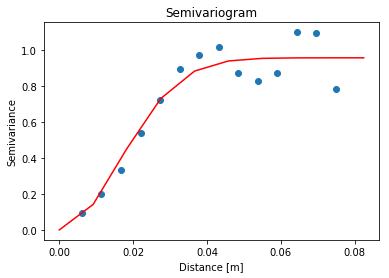

In [18]:
param, lag, fig = variogram.auto_vario(vario, 14)

In [25]:
print(param)

[1.00000000e+00 1.00000000e+02 2.51870094e-19 9.55335130e-01
 2.28943081e-02]


Step3: gls推定

In [28]:
distance_mat = kriging.calc_distance_matrix(data, ['px', 'py'])

In [164]:
efrange, c0 = kriging.calc_c0(param, distance_mat)

In [165]:
print(efrange)

0.1499187183409662


In [166]:
print(c0)

0.357934488492707


In [167]:
print(distance_mat)

[[0.         0.07977522 0.07414472 ... 0.1456904  0.14342874 0.14034726]
 [0.07977522 0.         0.00706137 ... 0.10275067 0.10323014 0.10451886]
 [0.07414472 0.00706137 0.         ... 0.10051429 0.10066822 0.10147933]
 ...
 [0.1456904  0.10275067 0.10051429 ... 0.         0.00499936 0.01262236]
 [0.14342874 0.10323014 0.10066822 ... 0.00499936 0.         0.00762327]
 [0.14034726 0.10451886 0.10147933 ... 0.01262236 0.00762327 0.        ]]


In [168]:
covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)

0.5975006417762274


In [169]:
print(covariance_mat)

[[0.95543513 0.72348906 0.75140113 ... 0.37801946 0.38897181 0.40411599]
 [0.72348906 0.95543513 0.95325671 ... 0.60239453 0.59980155 0.59282822]
 [0.75140113 0.95325671 0.95543513 ... 0.6144749  0.61364431 0.60926526]
 ...
 [0.37801946 0.60239453 0.6144749  ... 0.95543513 0.95429277 0.94870993]
 [0.38897181 0.59980155 0.61364431 ... 0.95429277 0.95543513 0.95291321]
 [0.40411599 0.59282822 0.60926526 ... 0.94870993 0.95291321 0.95543513]]


In [170]:
res, resid = kriging.do_gls(y, x, covariance_mat)

In [171]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.278
Model:                            GLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     24.20
Date:                Sat, 16 Mar 2019   Prob (F-statistic):           1.28e-09
Time:                        17:47:30   Log-Likelihood:                 54.814
No. Observations:                 128   AIC:                            -105.6
Df Residuals:                     126   BIC:                            -99.92
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
station      -21.9543      3.261     -6.733      0.000     -28.407     -15.501
tokyo         31.1427     16.735      1.861      0.065      -1.976      64.261
==============================================================================
Omnibus:                        0.920   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.515
Skew:                           0.090   Prob(JB):                        0.773
Kurtosis:                       3.253   Cond. No.                         5.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Step4: kirigng
- 距離行列作成
- 共分散関数作成
- 足し合わせ

In [172]:
mdat = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_pred.csv')
mdat.head()

,px,py,price,station,tokyo
0,139.402984,35.767626,NaN,0.017537,0.374249
1,139.407036,35.767626,NaN,0.013571,0.370307
2,139.411089,35.767626,NaN,0.009675,0.366367
3,139.439457,35.767626,NaN,0.001584,0.338865
4,139.394878,35.763700,NaN,0.026327,0.381271


In [173]:
mpoints = mdat[['px', 'py']].values
mexog = mdat[['station', 'tokyo']].values

In [174]:
points = data[['px', 'py']].values

In [175]:
new_dist_mat = kriging.calc_distance_new_data(mpoints, points)

In [176]:
c_mat = kriging.est_covariance_matrix(new_dist_mat, param, c0, reg=False)

In [177]:
fitted_val = kriging.put_pred_val(res, mexog)

In [180]:
kriging_val = kriging.do_kriging(fitted_val, c_mat, covariance_mat, resid)

## Rでの結果との比較

In [181]:
res_inR = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/krig_res_R.csv')
res_inR = res_inR.iloc[:, 1:-2]

Text(0, 0.5, 'pred by Python')

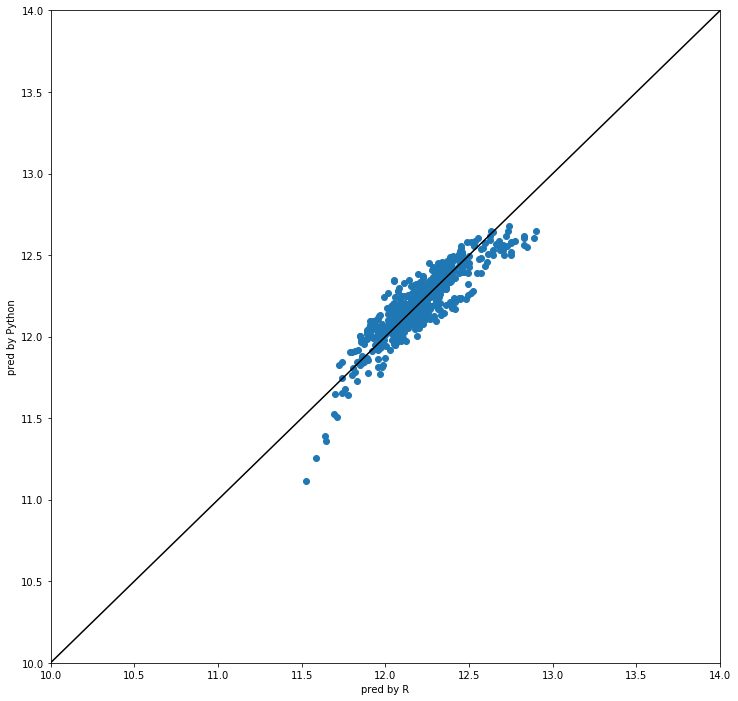

In [182]:
res_fig = plt.figure(figsize=(12, 12))
res_ax = res_fig.add_subplot(1, 1, 1)
res_ax.scatter(res_inR['var1.pred'], kriging_val)
res_ax.plot(np.linspace(10, 14, 1000), np.linspace(10, 14, 1000), color='black')
res_ax.set_xlim(10, 14)
res_ax.set_ylim(10, 14)
res_ax.set_xlabel('pred by R')
res_ax.set_ylabel('pred by Python')
# よりRとの結果と整合的になった

In [133]:
res_fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/kriging_est_func_res.png')